In [ ]:
# Imports
import os
import time
from datetime import datetime
import tqdm

import numpy as np
import pandas as pd
import scipy.io
import scipy

import copy
import tarfile

import matplotlib.pyplot as plt

In [ ]:
# Torch imports
import torch
import torchvision

from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import AlexNet_Weights
import torchvision.transforms as transforms
from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Set device to GPU if avaliable
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [ ]:
# Mount drive for training data set
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For both alexnet and vgg16, input_size should be set to 224
input_size = 224

# ---------------------------------------------------------------------------------
batch_size = 128
num_epochs = 20
# ---------------------------------------------------------------------------------

In [ ]:
# Initialize data transforms

data_transform_train = transforms.Compose([
    transforms.RandomResizedCrop(input_size), # Varför just RandomResizedCrop? Måste nog läsa om VGG16
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transform_val = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Extract data contained in Tar Files, avaliable data sets:
# CUB_200_2011.tar

dir = '/content/drive/MyDrive/DD2412/'

# ---------------------------------------------------------------------------------
dataset_name = 'CUB_200_2011.tar'
# --------------------------------------------------------------------------------

# Specify the path to the uploaded .tar file
tar_file_path = dir + dataset_name  # Replace with your file's name

# Specify the target directory where you want to extract the contents
target_directory = '/content/extracted_data/'  # Replace with your desired directory

# Create the target directory if it doesn't exist
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

# Extract the contents of the .tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(target_directory)

metadata_dir = './extracted_data/CUB_200_2011/'

class_df = pd.read_csv(metadata_dir + 'classes.txt', delimiter=' ', header=None, names = ['Index', 'Class'])

num_classes = len(class_df['Class'])


# Create DataLoaders for the data extracted above

data_dir = './extracted_data/CUB_200_2011/images'

training_set = datasets.ImageFolder(data_dir, transform=data_transform_train)
val_test_set = datasets.ImageFolder(data_dir, transform=data_transform_val)

train_test_df = pd.read_csv(metadata_dir + 'train_test_split.txt',
                               delimiter=' ', header=None,
                               names = ['Index', 'train_test'])

num_train = len(training_set)
indices = list(range(num_train))
# print(len(indices))

train_test_indices = np.array(train_test_df['train_test'])
train_indices = np.arange(num_train)[train_test_indices==1]
val_test_indices = np.arange(num_train)[train_test_indices==0]


np.random.shuffle(val_test_indices)

split = int(0.5*len(val_test_indices))

val_indices = val_test_indices[:split]
test_indices = val_test_indices[split:]

train_data = Subset(training_set, indices=train_indices)
val_data = Subset(val_test_set, indices=val_indices)
test_data = Subset(val_test_set, indices=test_indices)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

class_names = list(class_df['Class'])

# TODO: Lägg eventuellt till fler sorters data

In [ ]:
# Function for extracting data from torchvision.datasets
# FGVC Aircraft
# Food 101

def get_torch_data(target_name, batch_size):
  target_directory = '/content/extracted_data/' + target_name
  if not os.path.exists(target_directory):
    os.makedirs(target_directory)

  if target_name == 'FGVC_Aircraft/':
    # FGVCAircraft
    train_data = torchvision.datasets.FGVCAircraft(root = target_directory,
                                  split = 'train',
                                  annotation_level='variant',
                                  transform=data_transform_train,
                                  download=True)
    val_data = torchvision.datasets.FGVCAircraft(root = target_directory,
                                      split = 'val',
                                      annotation_level='variant',
                                      transform=data_transform_val,
                                      download=True)
    num_classes = 100 #https://pytorch.org/vision/main/generated/torchvision.datasets.FGVCAircraft.html
    class_names = []
    with open(target_directory + 'fgvc-aircraft-2013b/data/variants.txt', "r") as file:
      for line in file:
        class_name =line.strip()
        class_names.append(class_name)
  elif target_name == 'Food_101/':
    # Food101
    # TODO: Split test data into validation and testing
    train_data = torchvision.datasets.Food101(root = target_directory,
                                          split = 'train',
                                          transform=data_transform_train,
                                          download = True)
    val_data = torchvision.datasets.Food101(root = target_directory,
                                              split = 'test',
                                              transform=data_transform_val,
                                              download = True)
    num_classes = 101 # https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html
    class_names = []
  elif target_name == 'Flowers_102/':
    # Flowers102
    train_data = torchvision.datasets.Flowers102(root = target_directory,
                                                 split = 'train',
                                                 transform = data_transform_train,
                                                 download = True)
    val_data = torchvision.datasets.Flowers102(root = target_directory,
                                               split = 'val',
                                               transform = data_transform_val,
                                               download = True)
    num_classes = 102 # https://pytorch.org/vision/stable/generated/torchvision.datasets.Flowers102.html
    class_names = []
    class_names_dict = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue",
                        "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers",
                        "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy",
                        "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus",
                        "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6":
                        "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood",
                        "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower",
                        "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris",
                        "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris",
                        "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone",
                        "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea",
                        "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower",
                        "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum",
                        "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia",
                        "5": "english marigold", "92": "bee balm", "28": "stemless gentian",
                        "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold",
                        "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya",
                        "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily",
                        "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise",
                        "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine",
                        "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary",
                        "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea",
                        "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower",
                        "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium",
                        "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily",
                        "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani",
                        "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower",
                        "77": "passion flower", "51": "petunia"} # https://github.com/Muhammad-MujtabaSaeed/102-Flowers-Classification/tree/master
    for i in range(1,num_classes+1):
      class_names.append(class_names_dict[str(i)])
  elif target_name == 'Stanford_Cars/':
    # Stanford Cars
    train_data = torchvision.datasets.StanfordCars(root = target_directory,
                                                   split = 'train',
                                                   transform = data_transform_train,
                                                   download = True)
    val_data = torchvision.datasets.StanfordCars(root = target_directory,
                                                 split = 'test',
                                                 transform = data_transform_val,
                                                 download = True)
    num_classes = 196 # https://pytorch.org/vision/main/generated/torchvision.datasets.StanfordCars.html
    class_names = []
  train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)
  val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=True, drop_last=True)

  # TODO: !!! class_names
  return train_dataloader, val_dataloader, num_classes, class_names


In [ ]:
# Get data from torchvision.datasets
# FGVC Aircraft
# Food 101

# ---------------------------------------------------------------------------------
# target_name = 'FGVC_Aircraft/'
# target_name = 'Food_101/'
target_name = 'Flowers_102/'
# target_name = 'Stanford_Cars/'
# --------------------------------------------------------------------------------

train_dataloader, val_dataloader, num_classes, class_names = get_torch_data(target_name, batch_size)


In [ ]:
# Functions for loading pretrained model
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def unset_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = True

def initialize_vgg16(num_classes, feature_extract):
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    set_parameter_requires_grad(model, feature_extract)
    # Change the output size (out_features) of the last layer of vgg16
    # to be the amount of classes in the new dataset
    model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features,
                                          num_classes)
    input_size = 224 # https://keras.io/api/applications/vgg/
    preprocess = VGG16_Weights.IMAGENET1K_V1.transforms()
    return model, input_size, preprocess

def initialize_alexnet(num_classes, feature_extract):
  model = models.alexnet(weights='DEFAULT')
  set_parameter_requires_grad(model, feature_extract)
  model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)
  input_size = 224      # TODO: Källa?
  preprocess = AlexNet_Weights.DEFAULT.transforms()
  return model, input_size, preprocess


In [ ]:
# Load Pretrained model

# --------------------------------------------------------------------------------
# Feature extract
# True - Only the last layer is fine tuned
# False - The entire architecture is fine tuned
feature_extract = True

# VGG16
model, input_size, preprocess = initialize_vgg16(num_classes, feature_extract)

# AlexNet
# model, input_size, preprocess = initialize_alexnet(num_classes, feature_extract)
# ---------------------------------------------------------------------------------

model = model.to(device)

In [ ]:
# --------------------------------------------------------------------------------
# Initialize loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Intitialize optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())
# --------------------------------------------------------------------------------

In [ ]:
model_state_dict = torch.load('./drive/MyDrive/DD2412/vgg16/cub200/1.pth')

feature_extract = False
model, _, _ = initialize_vgg16(num_classes, feature_extract)
model.load_state_dict(model_state_dict)
model = model.to(device)

In [ ]:
def fine_tune_model(model, train_dataloader, val_dataloader,
                    optimizer, loss_fn, num_epochs=100):
    start_time = time.time()
    current_best_model = copy.deepcopy(model.state_dict())
    current_best_accuracy = 0.0

    epoch_number = 0

    best_val_loss = 1000000

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []


    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      model.train()
      running_loss = 0.0
      running_corrects = 0

      for i, data in enumerate(train_dataloader):
        print(i)
        inputs, labels = data
        # GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)


      avg_loss = running_loss / (i+1)
      avg_acc = running_corrects.double() / (len(inputs)*(i+1))

      running_val_loss = 0.0
      running_val_corrects = 0

      # Set the model to evaluation mode, disabling dropout and using population
      # statistics for batch normalization.
      model.eval()

      # Disable gradient computation and reduce memory consumption
      #
      # when you are sure that you will not call Tensor.backward()
      # it will reduce memory consumption for computations that would
      # otherwise have requires_grad=True.
      with torch.no_grad():
        for i, val_data in enumerate(val_dataloader):
          val_inputs, val_labels = val_data
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = loss_fn(val_outputs, val_labels)
          running_val_loss += val_loss.item()
          _, val_preds = torch.max(val_outputs, 1)
          running_val_corrects += torch.sum(val_preds == val_labels.data)

      avg_val_acc = running_val_corrects.double() /((i+1)*len(val_inputs))
      avg_val_loss = running_val_loss / (i+1)
      print('loss: training {}, validation {}\naccuracy: training {}, validation {}'.format(avg_loss,
                                                                   avg_val_loss, avg_acc, avg_val_acc))

      #writer.add_scalars('Training vs. Validation loss',
      #                   { 'Training' : avg_loss, 'Validation' : avg_val_loss},
      #                   epoch_number + 1)
      #writer.flush()

      # Track best performance, and save the model's state
      if current_best_accuracy < avg_val_acc:
        current_best_accuracy = avg_val_acc
        current_best_model = copy.deepcopy(model.state_dict())
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        # torch.save(model.state_dict(), model_path)

      epoch_number += 1

      train_loss_history.append(avg_loss)
      train_acc_history.append(avg_acc)
      val_loss_history.append(avg_val_loss)
      val_acc_history.append(avg_val_acc)

    time_elapsed = time.time() - start_time
    print('Training complete, {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return current_best_model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [ ]:
model_state_dict, tlh, vlh, tah, vah = fine_tune_model(model,
                                            train_dataloader,
                                            val_dataloader,
                                            optimizer,
                                            loss_fn,
                                            num_epochs=num_epochs)


In [ ]:
def cpuconvert(input_list):
  result = []
  for item in input_list:
    result.append(item.cpu().numpy())
  return np.array(result)

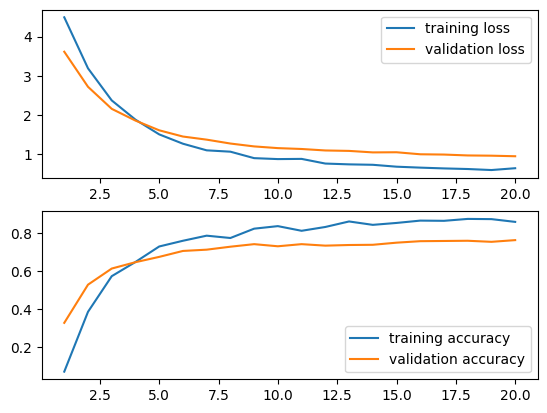

In [ ]:
# Plot loss and accuracy
# tlh1 = cpuconvert(tlh)
# vlh1 = cpuconvert(vlh)
tah1 = cpuconvert(tah)
vah1 = cpuconvert(vah)

fig, axs = plt.subplots(2,1)
axs[0].plot(range(1,num_epochs+1), tlh, label='training loss')
axs[0].plot(range(1,num_epochs+1), vlh, label='validation loss')
axs[1].plot(range(1,num_epochs+1), tah1, label='training accuracy')
axs[1].plot(range(1,num_epochs+1), vah1, label='validation accuracy')
axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
# Plots to check if the model looks reasonable

# # Plot current model
# model_name = 'vgg16'
# data_name = 'fgvc'
# model_dir = './saved_models/' + model_name + '/' + data_name + '/'
# model_state_dict = torch.load(model_dir+'1.pth')

# Take model from saved models
# './drive/MyDrive/DD2412/vgg16/cub200/1.pth'
# './drive/MyDrive/DD2412/vgg16/fgvc/1.pth'
# './drive/MyDrive/DD2412/vgg16/flowers/1.pth'
model_state_dict = torch.load('./drive/MyDrive/DD2412/vgg16/cub200/1.pth')

feature_extract = True
model, _, _ = initialize_vgg16(num_classes, feature_extract)
model.load_state_dict(model_state_dict)
model = model.to(device)


In [ ]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [ ]:
print(class_names)
for i, val_data in enumerate(val_dataloader):
  val_inputs, val_labels = val_data
  val_inputs = val_inputs.to(device)
  val_labels = val_labels.to(device)

  # model.load_state_dict(torch.load(model_dir + '1.pth'))
  model.eval()
  val_outputs = model(val_inputs)
  _, val_preds = torch.max(val_outputs, 1)

  inv_val_inputs = invTrans(val_inputs)
  for i in range(10):
    # if val_labels[i]==1:
    print('label: {}, pred: {}'.format(val_labels[i], val_preds[i]))
    print('label: {}, pred: {}'.format(class_names[val_labels[i]], class_names[val_preds[i]]))
    plt.imshow(inv_val_inputs[i].cpu().permute(1, 2, 0))
    plt.show()
    print('\n')
  break

In [ ]:
val_acc_list = []

running_val_corrects = 0

for i, val_data in enumerate(val_dataloader):
  print(i)
  val_inputs, val_labels = val_data
  val_inputs = val_inputs.to(device)
  val_labels = val_labels.to(device)

  model.eval()
  val_outputs = model(val_inputs)
  _, val_preds = torch.max(val_outputs, 1)
  # print(val_preds)
  # print(val_labels.data)
  running_val_corrects += torch.sum(val_preds == val_labels.data)
  print(running_val_corrects)
  print(len(val_inputs))
  avg_val_acc = running_val_corrects.double() /((i+1)*len(val_inputs))
  print(avg_val_acc)
  print('\n')
  val_acc_list.append(avg_val_acc.cpu())

print(val_acc_list)
print(np.array(val_acc_list).mean())


In [ ]:
# Save the model
# vgg16
# alexnet

# cub200
# fgvc
# flowers
# ...

model_name = 'vgg16'
data_name = 'flowers'
model_dir = './saved_models/' + model_name + '/' + data_name + '/'
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

torch.save(model_state_dict, model_dir + '1.pth')

# Save training plots
np.save(model_dir + 'tlh.npy', np.array(tlh))
np.save(model_dir + 'vlh.npy', np.array(vlh))
np.save(model_dir + 'tah.npy', np.array(tah1))
np.save(model_dir + 'vah.npy', np.array(vah1))

# Code to load model, USE in future applications